In [2]:
import os
import pandas as pd

DIR_DATA = os.path.join("..", "data")
PATH_DATA_TRAIN = os.path.join(DIR_DATA, "train.csv")
PATH_DATA_TEST = os.path.join(DIR_DATA, "test.csv")

In [3]:
df_train = pd.read_csv(PATH_DATA_TRAIN)

In [4]:
from collections import defaultdict
import math
import time
from multiprocessing import Pool, Manager, Process
import multiprocessing
from markov_helper import count_ngrams, progress_monitor
import decimal

MARKOV_DEF_SMOOTHING_WEIGHT = .1
MARKOV_DEF_VOCAB_SIZE = 95
MARKOV_MULTITHREAD_NUM_WORKERS = multiprocessing.cpu_count() - 2

class MarkovModel:
    order: int
    ngram_freqs: list[dict]
    totals: list[int]
    vocab_size: int
    __smoothing_weight__: float
    __smoothing_normalizer__: int
    __smoothing_weight_norm__: int
    __pool__ = Pool(processes=MARKOV_MULTITHREAD_NUM_WORKERS)
    __manager__ = Manager()
    __type__ = None

    def __init__(self, order: int, sequences: list = [], multithread: bool = True, verbose: bool = False, 
                 vocab_size: int = MARKOV_DEF_VOCAB_SIZE, smoothing_weight: float = MARKOV_DEF_SMOOTHING_WEIGHT):
        assert(order >= 0)

        self.order = order
        self.ngram_freqs = [defaultdict(int)] * (order + 1)
        self.totals = [0] * (order + 1)
        self.vocab_size = vocab_size
        self.set_smoothing_weight(smoothing_weight)

        if (len(sequences) > 0):
            if isinstance(sequences[0], str):
                self.__type__ = str
            elif isinstance(sequences[0], list):
                self.__type__ = list
            else:
                raise TypeError(f'sequences argument must be either a list of strings or list of lists (is list[{type(sequences[0])}]).')

            start = time.time()

            if (multithread):
                processes = [None] * (order + 1)  
                progresses = [None] * (order + 1)

                try:
                    for n in range(order + 1):
                        progresses[n] = MarkovModel.__manager__.Value('i', 0)
                        process = MarkovModel.__pool__.apply_async(count_ngrams, args=(sequences, n, progresses[n]))
                        processes[n] = process   

                    if verbose:
                        monitor = Process(target=progress_monitor, args=(progresses, order + 1, len(sequences)))
                        monitor.start()
                    
                    for n in range(len(processes)):
                        (total, frequencies) = processes[n].get()
                        self.totals[n] = total
                        self.ngram_freqs[n] = frequencies
                    
                except Exception as e:
                    MarkovModel.__pool__.terminate()
                    MarkovModel.__pool__ = Pool(processes=MARKOV_MULTITHREAD_NUM_WORKERS)
                    raise e
                finally:
                    if verbose:
                        monitor.terminate()
                    
            else:
                i = 0
                for seq in sequences:
                    i += 1
                    if i % 10 == 0:
                        print(f'Counting NGrams for Markov Model: {(i / len(sequences) * 100):>5.2f}%', end='\r')
                    for n in range(0, order + 1):
                        for pos in range(len(seq) - n):
                            ngram = seq[pos:pos+n+1]
                            self.add_ngram_occurrence(ngram)

            duration = time.time() - start
            if verbose:
                print(f'Order {order} Markov Model of {len(sequences)} sequences built in {duration:.3f} seconds!')

    def __str__(self):
        return f'{self.order}-Order Markov NGram Object - Totals: {self.totals}'
    
    def __check_len__(self, l):
        if l > self.order + 1 or l == 0:
            raise ValueError(f'Invalid NGram - Length of ngram must be between 1 and {self.order + 1} for an order {self.order} NGrams object (is {l})')

    @classmethod
    def __tuple_from_list__(cls, l: list):
        t = (l[0],)
        for item in l[1:]:
            t += (item,)

        return t
    
    def __check_type__(self, a):
        if not isinstance(a, self.__type__):
            raise TypeError(f'Argument must be of type {self.__type__} (is {type(a)})')
        
    def set_smoothing_weight(self, weight):
        self.__smoothing_weight__ = weight
        self.__smoothing_normalizer__ = (10 ** (-1 * decimal.Decimal(str(self.__smoothing_weight__)).as_tuple().exponent))
        self.__smoothing_weight_norm__ = int(self.__smoothing_normalizer__ * self.__smoothing_weight__)
        # used to convert smoothing weight to int for large numbers
        assert(self.__smoothing_weight_norm__ == (self.__smoothing_normalizer__ * self.__smoothing_weight__))

    def add_ngram_occurrence(self, ngram):
        self.__check_len__(len(ngram))
        self.__check_type__(ngram)
        self.ngram_freqs[len(ngram) - 1][MarkovModel.__tuple_from_list__(ngram)] += 1
        self.totals[len(ngram) - 1] += 1

    def get_total_occurrences(self, ngram):
        self.__check_len__(len(ngram))
        self.__check_type__(ngram)
        return self.ngram_freqs[len(ngram) - 1][MarkovModel.__tuple_from_list__(ngram)]
    
    def get_log_cond_prob(self, ngram):
        self.__check_len__(len(ngram))
        self.__check_type__(ngram)

        top = math.log((self.__smoothing_weight__ + self.get_total_occurrences(ngram)))
        occurrences_bot = self.totals[0] if (len(ngram) == 1) else self.get_total_occurrences(ngram[:-1])
        smoothing_bot = self.__smoothing_weight_norm__ * (self.vocab_size ** (max(len(ngram) - 1, 1)))
        bot = math.log(self.__smoothing_normalizer__) - math.log(smoothing_bot + self.__smoothing_normalizer__ * occurrences_bot) 

        return top + bot
    
    def get_log_sum_prob(self, seq: str):
        # TODO: how to handle empty sequences (high or low value?)
        # if (len(seq) == 0):
        #     raise ValueError(f'Invalid Sequence - Cannot get probability for an empty list')

        start = 0
        end = 1
        sum = 0

        while (end <= len(seq)):
            sum += self.get_log_cond_prob(seq[start:end])
            end += 1

            # ngrams can be at most order + 1 characters long:
            if (end - start > self.order + 1):
                start += 1
        return sum


In [5]:
texts_pos = (df_train.loc[df_train['target'] == 1])['text'].to_list()
texts_neg = (df_train.loc[df_train['target'] == 0])['text'].to_list()

MARKOV_ORDER = 10

model_pos = MarkovModel(MARKOV_ORDER, texts_pos, verbose=True)
model_neg = MarkovModel(MARKOV_ORDER, texts_neg, verbose=True)
model_pos2 = MarkovModel(MARKOV_ORDER, texts_pos, multithread=False, verbose=True)
model_neg2 = MarkovModel(MARKOV_ORDER, texts_neg, multithread=False, verbose=True)

def compare(sequence: str):
    pos1 = model_pos.get_log_sum_prob(sequence)
    pos2 = model_pos2.get_log_sum_prob(sequence)
    neg1 = model_neg.get_log_sum_prob(sequence)
    neg2 = model_neg2.get_log_sum_prob(sequence)

    print(f'Positives match: {pos1 == pos2}, Negatives match: {neg1 == neg2}')

compare("They should all die! All of them! Everything annihilated!")
compare("@sakuma_en If you pretend to feel a certain way the feeling can become genuine all by accident. -Hei (Darker than Black) #manga #anime")
compare("Shot 12 times. Found dead in cuffs after being involved in a car accident. Officers told ambulance not to treat him. https://t.co/MEUDJwaaNg")
compare("@NinaHoag - 'if you shred my Psych work our friendship would be annihilated")
compare("Why should a helicopter ambulance ride to transfer to a hospital 21 miles away cost $29800?")
compare("If you build an army of 100 lions and their leader is a dog in any fight the lions will die like a dog.")
compare("One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1424")

Order 10 Markov Model of 3271 sequences built in 0.522 seconds!
Order 10 Markov Model of 4342 sequences built in 0.644 seconds!
Order 10 Markov Model of 3271 sequences built in 2.777 seconds!
Order 10 Markov Model of 4342 sequences built in 3.349 seconds!
Positives match: True, Negatives match: True
Positives match: True, Negatives match: True
Positives match: True, Negatives match: True
Positives match: True, Negatives match: True
Positives match: True, Negatives match: True
Positives match: True, Negatives match: True
Positives match: True, Negatives match: True


In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class ConfusionMatrix:
    tp: int
    fp: int
    tn: int
    fn: int

    def __init__(self, tp: int = 0, tn: int = 0, fp: int = 0, fn: int = 0):
        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

    def __str__(self):
        total = self.tp + self.fp + self.tn + self.fn
        return f'Total: {total:.1f}, TP: {self.tp:.1f}, TN: {self.tn:.1f}, FP: {self.fp:.1f}, FN: {self.fn:.1f}, Prc: {self.get_precision():.3f}, Rec. {self.get_recall():.3f}, F1: {self.get_f1():.3f}'
    
    def get_f1(self):
        return 2 * ((self.get_precision() * self.get_recall()) / (self.get_precision() + self.get_recall()))
    
    def get_precision(self):
        return self.tp / (self.tp + self.fp)

    def get_recall(self):
        return self.tp / (self.tp + self.fn) 

    def add(self, rhs: 'ConfusionMatrix'):
        self.tp += rhs.tp
        self.fp += rhs.fp
        self.tn += rhs.tn
        self.fn += rhs.fn

    def div(self, divisor):
        self.tp /= divisor
        self.fp /= divisor
        self.tn /= divisor
        self.fn /= divisor

    def get_display(self, cmap=plt.cm.Blues, display_labels=["Positive", "Negative"]):
        actual = ([1] * round(self.tp)) + ([0] * round(self.fp)) + ([0] * round(self.tn)) + ([1] * round(self.fn))
        pred = ([1] * round(self.tp)) + ([1] * round(self.fp)) + ([0] * round(self.tn)) + ([0] * round(self.fn))
        return ConfusionMatrixDisplay.from_predictions(y_pred=pred, y_true=actual, cmap=cmap, display_labels=display_labels)

    @classmethod
    def average(cls, matrices: list['ConfusionMatrix']):
        result = ConfusionMatrix()
        for cm in matrices:
            result.add(cm)
        result.div(len(matrices))

        return result
        

In [7]:
class MarkovClassifier:
    model_pos: MarkovModel
    model_neg: MarkovModel
    __log_prior_pos__: float
    __log_prior_neg__: float
    order: int

    def __init__(self, order: int, positives: list, negatives: list, verbose: bool = False, 
                 vocab_size: int = MARKOV_DEF_VOCAB_SIZE, smoothing_weight: float = MARKOV_DEF_SMOOTHING_WEIGHT):
        
        self.model_pos = MarkovModel(order, positives, multithread=True, verbose=verbose, vocab_size=vocab_size, smoothing_weight=smoothing_weight)
        self.model_neg = MarkovModel(order, negatives, multithread=True, verbose=verbose, vocab_size=vocab_size, smoothing_weight=smoothing_weight)
        self.__log_prior_pos__ = math.log(len(positives)) - math.log((len(positives) + len(negatives)))
        self.__log_prior_neg__ = math.log(len(negatives)) - math.log((len(positives) + len(negatives)))
        self.order = order

    def predict(self, seq) -> bool:
        return self.model_pos.get_log_sum_prob(seq) + self.__log_prior_neg__ > self.model_neg.get_log_sum_prob(seq) + self.__log_prior_neg__

    def eval(self, positives: list, negatives: list) -> ConfusionMatrix:

        res = ConfusionMatrix()

        for instance in positives:
            if self.predict(instance):
                res.tp += 1
            else:
                res.fn += 1

        for instance in negatives:
            if not self.predict(instance):
                res.tn += 1
            else:
                res.fp += 1
        
        return res
    

In [8]:
import regex as re

def get_crossval_sets(df: pd.DataFrame, num_sets: int):


    df_shuffled: pd.DataFrame = df.sample(frac=1, random_state=0)
    len_chunk = len(df) / num_sets

    sets = {}
    sets['train'] = [None] * num_sets
    sets['val'] = [None] * num_sets

    for i in range(num_sets):
        start = round(i * len_chunk)
        end = round((i + 1) * len_chunk)
        sets['val'][i] = df_shuffled.iloc[start:end,:]
        sets['train'][i] = df_shuffled[~df_shuffled.index.isin(sets['val'][i].index)]

    return sets

def get_wordlist(text: str) -> list[str]:
    cleaned = text.lower()
    cleaned = re.sub(r'https?:\/\/.*[\r\n]*|[^\w\s]', ' ', cleaned)
    return cleaned.split()

def get_instances(df: pd.DataFrame, target: int, mapping = lambda x: x):
    return list(map(mapping, (df.loc[df['target'] == target])['text'].to_list()))

In [9]:
def test_orders(df: pd.DataFrame, num_sets: int = 5, mapping = lambda x: x, order_min: int = 0, order_max: int = 15, 
                print_results: bool = False, vocab_size: int = MARKOV_DEF_VOCAB_SIZE, smoothing_weight: float = MARKOV_DEF_SMOOTHING_WEIGHT):

    order_max += 1
    sets = get_crossval_sets(df, num_sets)
    f1_scores = [0] * (order_max - order_min)
    cms = [None] * (order_max - order_min)

    for order in range(order_min, order_max):
        res = ConfusionMatrix()
        time_training = 0.0
        time_validation = 0.0

        for i in range(num_sets):
            start = time.time()
            classifier = MarkovClassifier(order, get_instances(sets['train'][i], 1, mapping), 
                                          get_instances(sets['train'][i], 0, mapping), 
                                          vocab_size=vocab_size, smoothing_weight=smoothing_weight)
            
            time_training += time.time() - start
            start = time.time()
            cm = classifier.eval(get_instances(sets['val'][i], 1, mapping), get_instances(sets['val'][i], 0, mapping))
            
            time_validation += time.time() - start
            res.add(cm)

        res.div(len(sets['train']))
        cms [order - order_min] = res
        # f1_scores[order - order_min] = res.get_f1()

        if print_results:
            print(f'Order {order} results: ', end='')
            print(res)
            print(f'Training: [Tot.: {time_training:5.3f}s, Avg.: {time_training / num_sets:5.3f}s], Validation: [Tot.: {time_validation:5.3f}s, Avg.: {time_validation / num_sets:5.3f}s]')

    f1_scores = map(ConfusionMatrix.get_f1, cms)
    max_f1_index = max((v, i) for i, v in enumerate(f1_scores))[1]
    return (max_f1_index, cms[max_f1_index])


In [10]:
NUM_SETS = 5

print(f'Best order character based: {test_orders(df_train, NUM_SETS, print_results=True, vocab_size=200, smoothing_weight=1)}')
print(f'Best order word based: {test_orders(df_train, NUM_SETS, get_wordlist, order_max=6, vocab_size=40000, print_results=True)}')

Order 0 results: Total: 1522.6, TP: 443.4, TN: 546.2, FP: 322.2, FN: 210.8, Prc: 0.579, Rec. 0.678, F1: 0.625
Training: [Tot.: 0.675s, Avg.: 0.135s], Validation: [Tot.: 1.380s, Avg.: 0.276s]
Order 1 results: Total: 1522.6, TP: 441.4, TN: 642.4, FP: 226.0, FN: 212.8, Prc: 0.661, Rec. 0.675, F1: 0.668
Training: [Tot.: 0.849s, Avg.: 0.170s], Validation: [Tot.: 2.065s, Avg.: 0.413s]
Order 2 results: Total: 1522.6, TP: 310.4, TN: 838.8, FP: 29.6, FN: 343.8, Prc: 0.913, Rec. 0.474, F1: 0.624
Training: [Tot.: 1.207s, Avg.: 0.241s], Validation: [Tot.: 2.357s, Avg.: 0.471s]
Order 3 results: Total: 1522.6, TP: 386.8, TN: 813.4, FP: 55.0, FN: 267.4, Prc: 0.876, Rec. 0.591, F1: 0.706
Training: [Tot.: 1.716s, Avg.: 0.343s], Validation: [Tot.: 2.785s, Avg.: 0.557s]
Order 4 results: Total: 1522.6, TP: 416.2, TN: 794.2, FP: 74.2, FN: 238.0, Prc: 0.849, Rec. 0.636, F1: 0.727
Training: [Tot.: 1.787s, Avg.: 0.357s], Validation: [Tot.: 2.862s, Avg.: 0.572s]
Order 5 results: Total: 1522.6, TP: 435.2, TN: 7

In [11]:
start = time.process_time()
cms_char = test_orders(df_train, 3, print_results=True, vocab_size=200, smoothing_weight=1, order_min=6, order_max=6)
time.sleep(1)
end = time.process_time()

print(f'Time elapsed: {end - start:.3f}s')

Order 6 results: Total: 2537.7, TP: 753.3, TN: 1251.3, FP: 196.0, FN: 337.0, Prc: 0.794, Rec. 0.691, F1: 0.739
Training: [Tot.: 1.305s, Avg.: 0.435s], Validation: [Tot.: 3.083s, Avg.: 1.028s]
Time elapsed: 3.655s


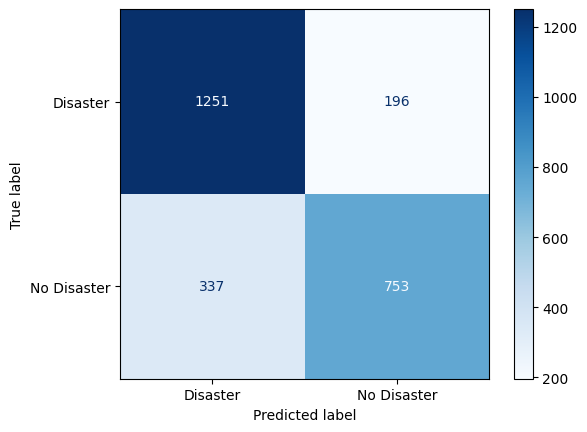

In [12]:
test = cms_char[1].get_display(display_labels=["Disaster", "No Disaster"])


In [39]:
df_test = pd.read_csv(PATH_DATA_TEST)

classifier = MarkovClassifier(0, get_instances(df_train, 1, get_wordlist), get_instances(df_train, 0, get_wordlist), verbose=True)
df_test['target'] = df_test['text'].apply(lambda seq: classifier.predict(get_wordlist(seq))).astype(int)

display(df_test)

Order 0 Markov Model of 3271 sequences built in 0.058 seconds!
Order 0 Markov Model of 4342 sequences built in 0.045 seconds!


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


1444


In [40]:
df_submission = df_test[['id', 'target']]
display(df_submission)
df_submission.to_csv(os.path.join(DIR_DATA, 'submission.csv'), index=False)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
